In [1]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [12]:
X, Y = datasets.load_iris(return_X_y=True)

In [28]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics

In [14]:
pca = decomposition.PCA()
pca.fit(X)

PCA()

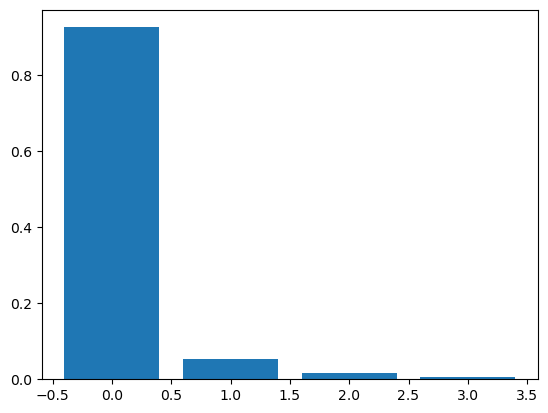

In [15]:
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

In [16]:
U = pca.transform(X)
U = U[:,:2]

In [17]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]

In [18]:
Y2[Y2 == 2] = -1
Y2 = Y2.astype('d')

In [19]:
U2 = preprocessing.scale(U2)

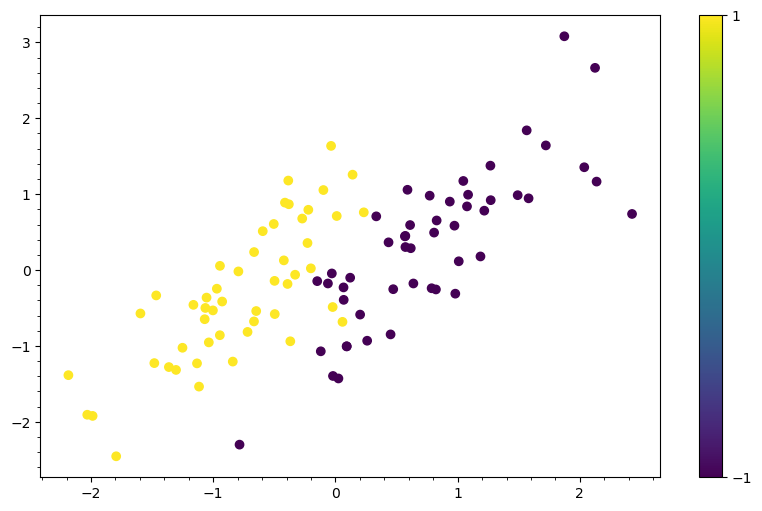

In [20]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U2[:,0], U2[:,1], c=Y2)
plt.colorbar(sc,ticks=[-1,+1])
plt.minorticks_on()
plt.show()

In [21]:
import sklearn.model_selection as model_selection

In [22]:
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
from mlgrad.cls import classification_as_regr
import mlgrad.plots as plots

In [26]:
def calc_zz(mod, min_val, max_val):
    xrange = np.linspace(min_val, max_val, 101)
    yrange = np.linspace(min_val, max_val, 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

0.96


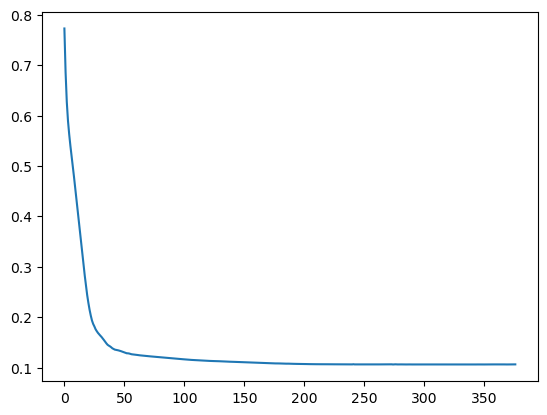

In [29]:
linmod = models.LinearModel(2)
lossfunc = loss.MarginLoss(funcs.Hinge(1.0))
alg = classification_as_regr(U2, Y2, linmod, lossfunc, h=0.1)
print(metrics.accuracy_score(Y2, np.sign(linmod.evaluate(U2))))
plt.plot(alg.lvals)
plt.show()

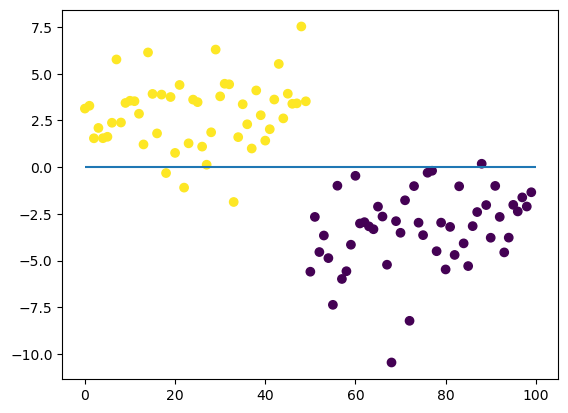

In [31]:
plt.scatter(range(len(Y2)), linmod.evaluate(U2), c=Y2)
plt.hlines(0, 0, len(Y2))
plt.show()            

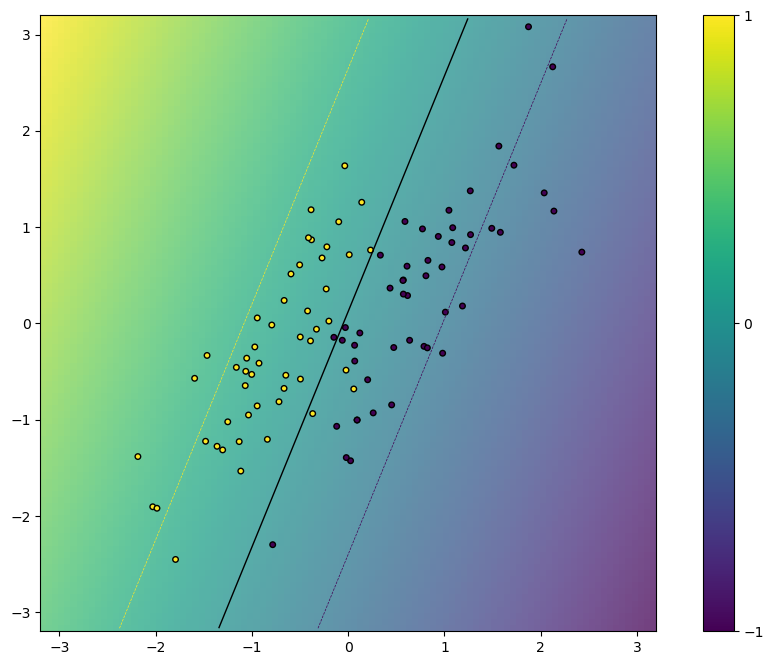

In [71]:
ZZ = calc_zz(linmod, -3.2, 3.2)
plt.figure(figsize=(12,8))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=16)
plt.imshow(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), alpha=0.75)
plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=1, colors='k')
plt.contour(ZZ, levels=[-5,5], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=0.5, linestyles='--')
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

In [47]:
c_train = []
c_test = []
for is_train, is_test in model_selection.StratifiedShuffleSplit(44, train_size=0.95).split(U2, Y2):
    lm = models.LinearModel(2)
    U2_train = U2[is_train]
    Y2_train = Y2[is_train]
    U2_test = U2[is_test]
    Y2_test = Y2[is_test]
    cls = classification_as_regr(U2_train, Y2_train, lm, lossfunc, h=0.1)
    sc_train = metrics.accuracy_score(Y2_train, np.sign(lm.evaluate(U2_train)))
    c_train.append(sc_train)
    sc_test = metrics.accuracy_score(Y2_test, np.sign(lm.evaluate(U2_test)))
    c_test.append(sc_test)    

Train: 0.9586124401913877 0.005213993951603682
Test: 0.9454545454545453 0.09875254992000194


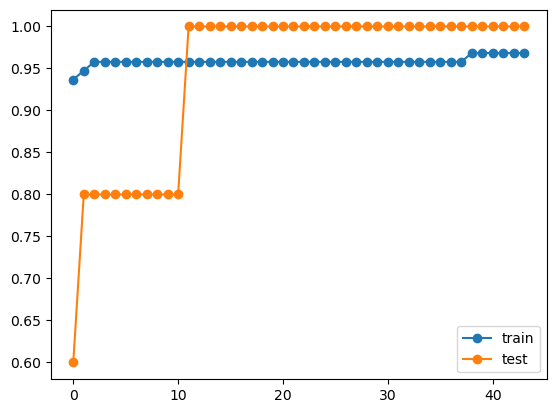

In [48]:
print(f"Train: {np.mean(c_train)} {np.std(c_train)}")
print(f"Test: {np.mean(c_test)} {np.std(c_test)}")
plt.plot(sorted(c_train), marker='o', label="train")
plt.plot(sorted(c_test), marker='o', label="test")
plt.legend()
plt.show()

In [81]:
def new_nn_model(n_hidden = 10):
    body = models.FFNetworkModel()
    body.add(models.LinearLayer(2, n_hidden))
    body.add(models.ScaleLayer(funcs.Sigmoidal(5.0), n_hidden))
    head = models.LinearModel(body.n_output)
    nnmod = models.FFNetworkFuncModel(head, body)
    nnmod.allocate()
    nnmod.init_param()
    return nnmod

In [83]:
nnmod = new_nn_model(10)

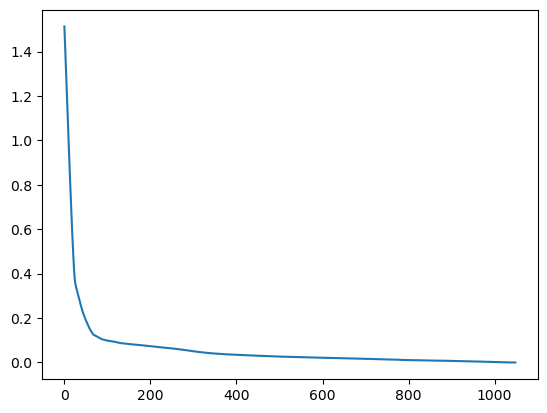

In [84]:
nn_cls = classification_as_regr(U2, Y2, nnmod, lossfunc, h=0.005, n_iter=2000)
plt.plot(nn_cls.lvals)
plt.show()

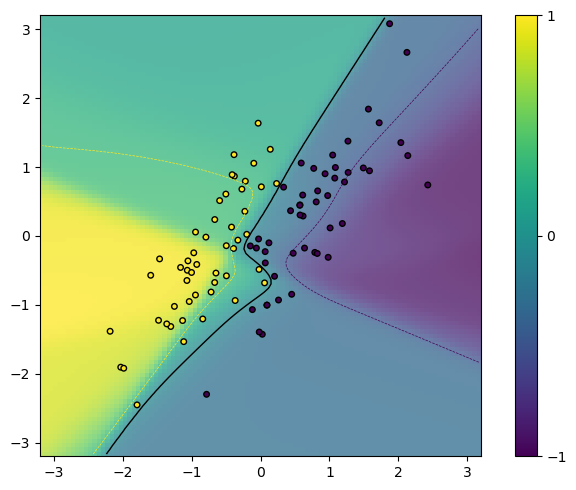

In [85]:
ZZ = calc_zz(nnmod, -3.2, 3.2)
plt.figure(figsize=(7,5))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=16)
plt.imshow(ZZ, origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), alpha=0.75)
plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=1, colors='k')
plt.contour(ZZ, levels=[-5,5], origin='lower', extent=(-3.2, 3.2,-3.2, 3.2), linewidths=0.5, linestyles='--')
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.tight_layout()
plt.show()

In [86]:
metrics.accuracy_score(Y2, np.sign(nnmod.evaluate(U2)))

1.0

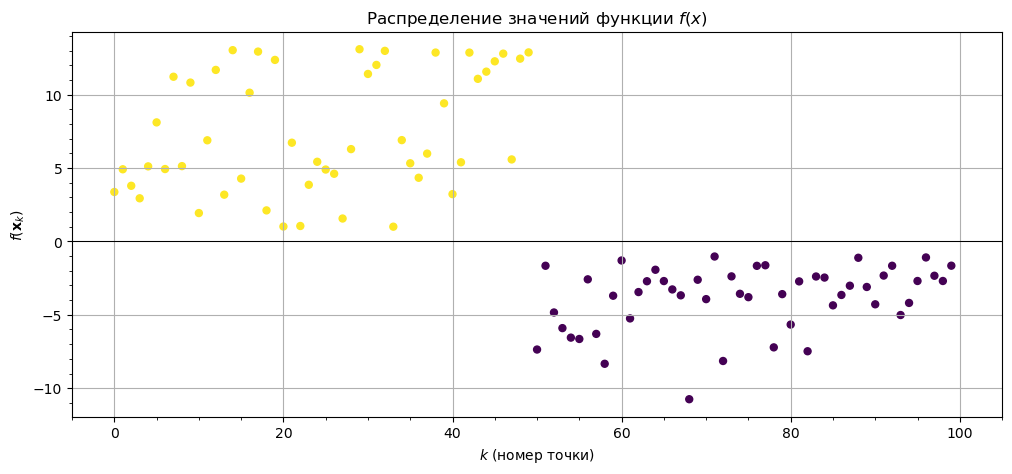

In [87]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()

In [90]:
c_train = []
c_test = []
for is_train, is_test in model_selection.StratifiedShuffleSplit(44, train_size=0.98).split(U2, Y2):
    nnmod = new_nn_model(10)
    U2_train = U2[is_train]
    Y2_train = Y2[is_train]
    U2_test = U2[is_test]
    Y2_test = Y2[is_test]
    cls = classification_as_regr(U2_train, Y2_train, nnmod, lossfunc, h=0.005, n_iter=2000)
    sc_train = metrics.accuracy_score(Y2_train, np.sign(nnmod.evaluate(U2_train)))
    c_train.append(sc_train)
    sc_test = metrics.accuracy_score(Y2_test, np.sign(nnmod.evaluate(U2_test)))
    c_test.append(sc_test)    

Train: 0.8903061224489797 0.13904816402971065
Test: 0.8409090909090909 0.27742171853940234


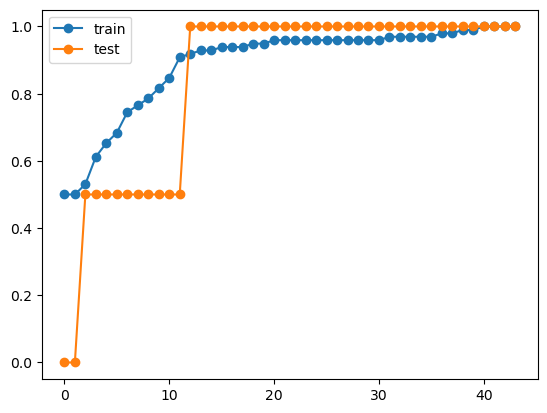

In [91]:
print(f"Train: {np.mean(c_train)} {np.std(c_train)}")
print(f"Test: {np.mean(c_test)} {np.std(c_test)}")
plt.plot(sorted(c_train), marker='o', label="train")
plt.plot(sorted(c_test), marker='o', label="test")
plt.legend()
plt.show()